<a href="https://colab.research.google.com/github/CGSData/Netflix-App-Reviews/blob/main/Netflix_App_Reviews_Gonzalez_Carlos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción y Presentación del Problema

Las aplicaciones móviles son esenciales en la vida diaria, y las opiniones de los usuarios son una valiosa fuente de retroalimentación. Este proyecto busca analizar el sentimiento de reseñas de usuarios sobre la aplicación de la plataforma 'Netflix', clasificándolas en categorías de positivo, negativo y neutral. A través de técnicas NLP y modelos de aprendizaje automático, se pretende obtener información sobre cómo los usuarios perciben la aplicación.

El problema consiste en clasificar automáticamente reseñas con texto libre utilizando métodos como TF-IDF y modelos como regresión logística y Naive Bayes. Se busca construir un sistema que pueda predecir de manera precisa el sentimiento de las reseñas, ayudando a los desarrolladores a mejorar la aplicación.

# Objetivos

Objetivo General:
Desarrollar un modelo de análisis de sentimiento para clasificar automáticamente las reseñas de usuarios sobre la aplicación móvil de la plataforma de entretenimiento 'Netflix' en categorías de positivo, negativo y neutral, utilizando técnicas de procesamiento de lenguaje natural y aprendizaje automático.

Objetivos Específicos:
Limpiar y transformar el texto de las reseñas, aplicando técnicas como tokenización, eliminación de stopwords y lematización.

Utilizar la técnica de TF-IDF para convertir las reseñas en vectores numéricos que puedan ser procesados por modelos de aprendizaje automático.

Implementar y entrenar modelos como regresión logística y Naive Bayes para clasificar las reseñas según su sentimiento.

Medir la precisión y efectividad de los modelos mediante métricas de evaluación como la exactitud y el informe de clasificación.

Probar el modelo entrenado en nuevas reseñas de usuarios para predecir su sentimiento y proporcionar retroalimentación sobre la percepción de la aplicación.

# Librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
import requests
import chardet
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


# Dataset

In [2]:
# Importamos dataset
URL = "https://github.com/CGSData/Netflix-App-Reviews/raw/a75e07e14b7bfdc5a9102e77f72cd0d9438dc575/netflix_reviews.csv"
response = requests.get(URL)
content = response.content

result = chardet.detect(content)
encoding = result['encoding']

df_net = pd.read_csv(URL, encoding=encoding)
df_net.head()


,reviewId,userName,review,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,fad76646-9d91-47d6-ae0e-f34d65722100,Usman Pk,Ok,5,0,NaN,11/11/2024 13:16,NaN
1,689ea35c-4290-4b6f-ba50-b3f5e883126c,Alexander Jim√©nez,I think this is an amazing app u can watch man...,4,0,8.139.1 build 24 51108,11/11/2024 13:10,8.139.1 build 24 51108
2,180f6abf-02d1-4e26-9061-307bff63d93d,Darius Blizzard,"Great app, just can't play Into the dead 2: Un...",4,0,8.139.1 build 24 51108,11/11/2024 13:09,8.139.1 build 24 51108
3,b30ae633-ed3b-4ebd-a8b4-4d9ff929f6de,Nathan Shotter,Real ii64,5,0,8.139.1 build 24 51108,11/11/2024 13:07,8.139.1 build 24 51108
4,9cf63d64-30df-448d-bfa5-58aa8aae8d1c,Masego Mnguni,I love Netflix it has serious and movies,5,0,NaN,11/11/2024 13:01,NaN


In [3]:
# Se crea un nuevo dataframe solo con las columnas utiles
df = df_net[['review', 'score']].copy()
df.head()

,review,score
0,Ok,5
1,I think this is an amazing app u can watch man...,4
2,"Great app, just can't play Into the dead 2: Un...",4
3,Real ii64,5
4,I love Netflix it has serious and movies,5


In [4]:
# Se revisa existencia de nulos
df.isna().sum() / len(df) * 100

,0
review,0.002523
score,0.000000


In [5]:
# Eliminar nulos
df.dropna(inplace=True)

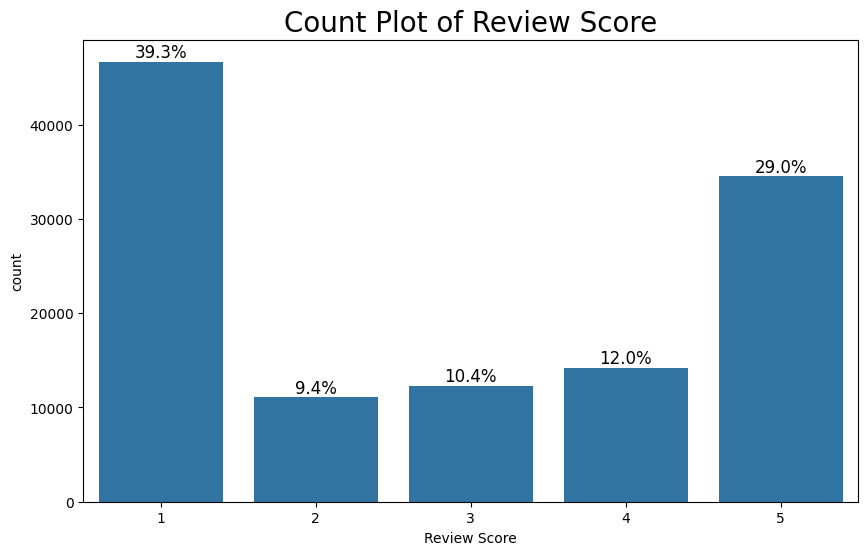

In [6]:
# Se grafica el porcentaje de cada score en el dataframe
plt.figure(figsize=(10, 6))
total = float(len(df))

ax = sns.countplot(x='score', data=df)
plt.title('Count Plot of Review Score', fontsize=20)
plt.xlabel('Review Score')

for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12)

plt.show()


In [7]:
# Se establece scores negativos, neutral o positivo
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df.score.apply(to_sentiment)

<ipython-input-8-b27926443c88>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


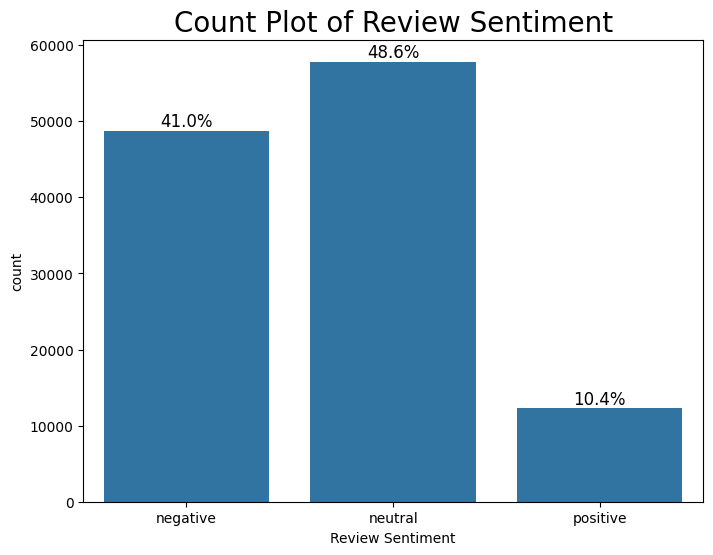

In [8]:
# Se grafica para ver porcentajes de scores
plt.figure(figsize=(8, 6))
total = float(len(df))
ax = sns.countplot(x='sentiment', data=df)

class_names = ['negative', 'neutral', 'positive']
ax.set_xticklabels(class_names)

plt.title('Count Plot of Review Sentiment', fontsize=20)
plt.xlabel('Review Sentiment')

for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12)

plt.show()


## Preprocesamiento

In [9]:
# Rellenar valores nulos en la columna 'reviews' con cadenas vacías
df['review'] = df['review'].fillna('')


In [10]:
# Limpieza del texto
def clean_text(text):
    # Verificar que el texto no sea None o vacío
    if not text:
        return ""

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenización
    tokens = word_tokenize(text)

    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Unir tokens en una cadena
    cleaned_text = ' '.join(tokens)

    return cleaned_text


In [11]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
df['cleaned_reviews'] = df['review'].apply(clean_text)

In [13]:
# Análisis de frecuencia de palabras
from collections import Counter

all_words = ' '.join(df['cleaned_reviews']).split()

word_freq = Counter(all_words)

print(word_freq.most_common(10))


[('netflix', 50833), ('app', 50754), ('movie', 36684), ('show', 27560), ('watch', 26289), ('good', 19011), ('like', 17062), ('cant', 15141), ('love', 14754), ('please', 12942)]


In [14]:
# Análisis morfologico
nltk.download('averaged_perceptron_tagger_eng')

df['pos_tags'] = df['cleaned_reviews'].apply(lambda x: nltk.pos_tag(x.split()))

print(df[['cleaned_reviews', 'pos_tags']].head())



[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


                                     cleaned_reviews  \
0                                                 ok   
1  think amazing app u watch many series movie ad...   
2  great app cant play dead 2 unleashed doesnt bo...   
3                                          real ii64   
4                         love netflix serious movie   

                                            pos_tags  
0                                         [(ok, NN)]  
1  [(think, VB), (amazing, VBG), (app, JJ), (u, J...  
2  [(great, JJ), (app, NN), (cant, JJ), (play, NN...  
3                           [(real, JJ), (ii64, NN)]  
4  [(love, VB), (netflix, RB), (serious, JJ), (mo...  


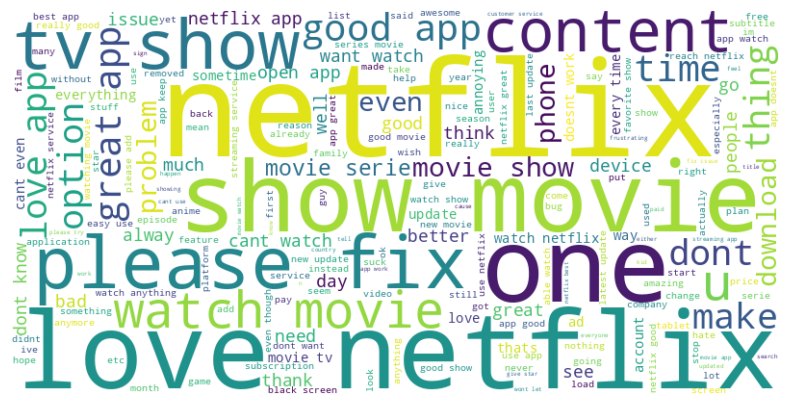

In [15]:
# Se crea una nube de palabras con todas las palabras
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(df['cleaned_reviews'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


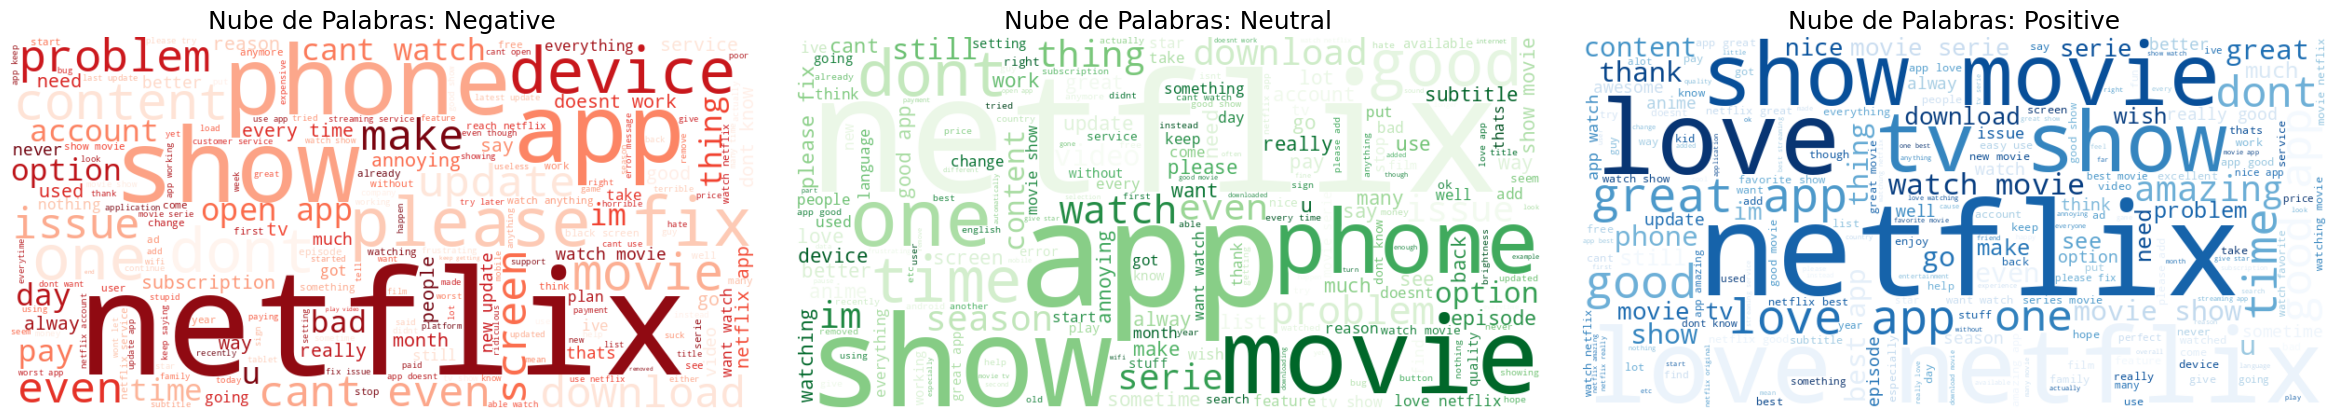

In [16]:
# Se crean nubes de palabras diferenciando entre reviews negativas, neutrales o positivas
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

colormap_list = ['Reds', 'Greens', 'Blues']

for i, sentiment in enumerate(['negative', 'neutral', 'positive']):
    text = ' '.join(df[df['sentiment'] == sentiment]['cleaned_reviews'].dropna())

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap_list[i]).generate(text)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Nube de Palabras: {sentiment.capitalize()}', fontsize=18)
    axes[i].axis('off')

plt.tight_layout(pad=3.0)
plt.show()


In [23]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

def parse_and_analyze_dependencies(text):
    doc = nlp(text)
    return doc

df['parsed_reviews'] = df['cleaned_reviews'].apply(parse_and_analyze_dependencies)

options = {
    "compact": True,
    "bg": "#fafafa",
    "color": "#000",
    "font": "Arial",
    "distance": 80
}


In [46]:
# Se visualiza el árbol sintáctico de la segunda reseña, ya que la primera es 'OK'
doc = df['parsed_reviews'].iloc[1]
displacy.render(doc, style='dep', jupyter=True, options=options)

# Modelos

## Logistic Regression con TF-IDF

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_reviews'], df['sentiment'], test_size=0.2, random_state=42
)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7906311761490266
Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.90      0.84     11712
     neutral       0.30      0.04      0.06      2404
    positive       0.81      0.84      0.83      9665

    accuracy                           0.79     23781
   macro avg       0.63      0.59      0.58     23781
weighted avg       0.75      0.79      0.76     23781



In [44]:
# Se prueba el modelo con diferentes reseñas
test_reviews = [
     "I absolutely love this app! It's so easy to use and very helpful.",
    "The app is okay, but could be improved with more features.",
    "I hate this app. It's buggy and crashes all the time.",
    "This app is amazing! It makes my life so much easier. Highly recommend!",
    "The app is alright, but I had some trouble with the registration process.",
    "Very disappointing. The app doesn't work as advertised and has constant errors.",
    "Good app but it freezes sometimes. I hope they fix it soon.",
    "I love this app! It's simple and efficient, just what I needed.",
    "Not great. The user interface is confusing and the app is slow.",
    "This app is terrible. It keeps crashing and I can't get it to work.",
    "Fantastic app! Everything works perfectly and it's super easy to use.",
    "The app is okay. It works, but it could use a few improvements.",
    "Worst app ever! It crashes all the time and is so frustrating to use.",
    "Decent app. Does what it says, but nothing extraordinary.",
    "The best app I've used for this purpose. Simple and effective."
]

test_reviews_tfidf = tfidf.transform(test_reviews)

predictions = model.predict(test_reviews_tfidf)

for review, prediction in zip(test_reviews, predictions):
    print(f'Review: "{review}"\nPredicted Sentiment: {prediction}\n')




Review: "I absolutely love this app! It's so easy to use and very helpful."
Predicted Sentiment: positive

Review: "The app is okay, but could be improved with more features."
Predicted Sentiment: positive

Review: "I hate this app. It's buggy and crashes all the time."
Predicted Sentiment: negative

Review: "This app is amazing! It makes my life so much easier. Highly recommend!"
Predicted Sentiment: positive

Review: "The app is alright, but I had some trouble with the registration process."
Predicted Sentiment: positive

Review: "Very disappointing. The app doesn't work as advertised and has constant errors."
Predicted Sentiment: negative

Review: "Good app but it freezes sometimes. I hope they fix it soon."
Predicted Sentiment: positive

Review: "I love this app! It's simple and efficient, just what I needed."
Predicted Sentiment: positive

Review: "Not great. The user interface is confusing and the app is slow."
Predicted Sentiment: positive

Review: "This app is terrible. It keep

## Naive Bayes con TF-IDF

In [32]:
# Mapear las etiquetas de sentimientos a valores numéricos
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_label'] = df['sentiment'].map(sentiment_mapping)


In [33]:
print(df[['sentiment', 'sentiment_label']].head())

  sentiment  sentiment_label
0  positive                2
1  positive                2
2  positive                2
3  positive                2
4  positive                2


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_reviews'])
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=sentiment_mapping.keys()))


Accuracy: 0.7714982549093814
Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.89      0.82     11712
     neutral       0.18      0.00      0.01      2404
    positive       0.78      0.82      0.80      9665

    accuracy                           0.77     23781
   macro avg       0.58      0.57      0.54     23781
weighted avg       0.71      0.77      0.73     23781



In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Función para predecir el sentimiento de una nueva reseña
def predict_sentiment(review, model, tfidf_vectorizer):
    cleaned_review = clean_text(review)

    review_tfidf = tfidf_vectorizer.transform([cleaned_review])

    sentiment_pred = model.predict(review_tfidf)

    sentiment_mapping_reverse = {0: 'negative', 1: 'neutral', 2: 'positive'}
    sentiment_label = sentiment_mapping_reverse[sentiment_pred[0]]

    return sentiment_label


In [37]:
# Se prueba el modelo con diferentes reseñas
new_reviews = [
    "I absolutely love this app! It's so easy to use and very helpful.",
    "The app is okay, but could be improved with more features.",
    "I hate this app. It's buggy and crashes all the time.",
    "This app is amazing! It makes my life so much easier. Highly recommend!",
    "The app is alright, but I had some trouble with the registration process.",
    "Very disappointing. The app doesn't work as advertised and has constant errors.",
    "Good app but it freezes sometimes. I hope they fix it soon.",
    "I love this app! It's simple and efficient, just what I needed.",
    "Not great. The user interface is confusing and the app is slow.",
    "This app is terrible. It keeps crashing and I can't get it to work.",
    "Fantastic app! Everything works perfectly and it's super easy to use.",
    "The app is okay. It works, but it could use a few improvements.",
    "Worst app ever! It crashes all the time and is so frustrating to use.",
    "Decent app. Does what it says, but nothing extraordinary.",
    "The best app I've used for this purpose. Simple and effective."
]

for review in new_reviews:
    sentiment = predict_sentiment(review, model, tfidf)
    print(f'Review: "{review}"\nPredicted Sentiment: {sentiment}\n')


Review: "I absolutely love this app! It's so easy to use and very helpful."
Predicted Sentiment: positive

Review: "The app is okay, but could be improved with more features."
Predicted Sentiment: positive

Review: "I hate this app. It's buggy and crashes all the time."
Predicted Sentiment: negative

Review: "This app is amazing! It makes my life so much easier. Highly recommend!"
Predicted Sentiment: positive

Review: "The app is alright, but I had some trouble with the registration process."
Predicted Sentiment: negative

Review: "Very disappointing. The app doesn't work as advertised and has constant errors."
Predicted Sentiment: negative

Review: "Good app but it freezes sometimes. I hope they fix it soon."
Predicted Sentiment: negative

Review: "I love this app! It's simple and efficient, just what I needed."
Predicted Sentiment: positive

Review: "Not great. The user interface is confusing and the app is slow."
Predicted Sentiment: positive

Review: "This app is terrible. It keep

# Conclusión

Después de realizados los modelos, es posible observar que ambos presentan resultados bastante similares, teniendo el modelo Logistic Regression con TF-IDF un presición del 0.79, mientras que el modelo Naive Bayes con TF-IDF tiene una presición del 0.77. Además de esto, se aprecia que ambos modelos tienen problemas identificando neutros, ya que solo marcan los ejemplos como positivo o negativo. También se ve que presentan diferencias al identificarlos ya que en el caso de la review de ejemplo "The app is alright, but I had some trouble with the registration process.", el modelo Logistic Regression lo considera como positivo, mientras que el modelo Naive Bayes lo considera como negativo, siendo esta reseña neutral.